# Tutorial on how to use the transit function and limb-darkening functions independent of the marginalisation framework

Here we will need to import the `margmodule` code from **ExoTiC-ISM**. If you have followed the install of the package and used the `setup.py` this will work anywhere as long as you are in the environment where it was installed.

Remember when using any part of the **ExoTiC-ISM** package please follow our `citation.txt` file

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.constants import G

# These are the important ones we are using from ExoTiC-ISM
from exoticism.limb_darkening import limb_dark_fit
import exoticism.margmodule as marg

Independent of the CONFIG file used in **ExoTiC-ISM**, you can manually input any paramters. These are the ones we will need for the limb-darkening, phase calculation, and transit model. 

Note that some require astropy unit designators to work properly with this code

In [2]:
# System parameters
# ------------------
# Star for limb-darkening
Teff = 6550
M_H = -0.25
logg = 4.2

# Planet - for these parameters you need to be specific about the units using astropy units
Per = 3.7 * u.d # days
Persec = Per.to(u.s) # seconds
inclin = 90.0 * u.deg # degrees

# System
aors = 7.0
# System density from aors and period
constant1 = ((G * np.square(Persec)) / (4 * np.square(np.pi))) ** (1 / 3)
MsMpR = (aors / constant1) ** 3.
# Planet to star radius ratio (Rp/Rs)
rl = 0.121 

### Limb-Darkening
If you dont want to compute the limb-darkening for whatever reason or you are doing an eclipse set c1-4 manually.

For an eclipse these should all be set equal to zero

See `margmodule.py` in **ExoTiC-ISM** for details on the `ld_model` and `grat` options

In [3]:
# Tell the code where on your computer the limb-darkening folder is
lcmod_folder = '/Users/iz19726/Documents/Exotic/ExoTiC-ISM/'

limbDir = os.path.join(lcmod_folder, 'Limb-darkening')
# choose which limb-darkening models set-up you want to use
ld_model = '3D'
grat = 'G141'
wavelength = np.loadtxt(os.path.join(lcmod_folder, 'data/W17/W17_G141_wavelength_test_data.txt'), comments='#')
_uLD, c1, c2, c3, c4, _cp1, _cp2, _cp3, _cp4, _aLD, _bLD = limb_dark_fit(grat, wavelength, M_H, Teff, logg, limbDir, ld_model)

You are using the 3D limb darkening models.
Current Directories Entered:
  /Users/iz19726/Documents/Exotic/ExoTiC-ISM/Limb-darkening
  /Users/iz19726/Documents/Exotic/ExoTiC-ISM/Limb-darkening/3DGrid
Filename: mmu_t65g40m00v05.flx

Closest values to your inputs:
Teff:  6500
M_H:  0.0
log(g):  4.0

Limb darkening parameters:
4param 	0.96471134	-1.08470006	0.94861860	-0.32529467
3param 	2.13885060	-3.11035859	1.39214549
Quad 	0.03041293	0.34401170
Linear 	0.32216663


### Impact Parameter
Here we will use the `marg.impact_param` to calculate the path of the planet across the star in terms of the stellar radii

#### Using a smooth high resolution phase array
Define the planetary phase of your transit for a smooth model

In [11]:
start_phase = -0.1
end_phase = 0.1
resolution = 0.0001
phase_smooth = np.arange(start_phase, end_phase, resolution)   # this is the x-array for the smooth model

b0_smooth = marg.impact_param(Persec, MsMpR, phase_smooth, inclin)  
# NOTE: period in sec here, incl in radians, b0 in stellar radii

#### Creating a phase array from data with time stamps
Or you can input data in time to calculate the phase given the period, or give an array of phases. Here we will again sample from our test files. Here the test files are in HJD so the epoch (center of transit) value is also in HJD. 

In [12]:
data = np.loadtxt(os.path.join(lcmod_folder,'data/W17/W17_G141_lightcurve_test_data.txt'), comments='#') 
# Data from ExoTiC-ISM test data
x = data[:,0]
x *= u.d # set the astropy units of this to days
y = data[:,1]
err = data[:,2]
epoch = 57957.970153390 * u.d # also note the need for the astropy unit
# Epoch values from ExoTiC-ISM test data 
# if you are fitting you transit model to data this will normally be set as a free parameter

phase_data = marg.phase_calc(x, epoch, Per)  # Per in days here

b0_data = marg.impact_param(Persec, MsMpR, phase_data, inclin) 
# NOTE: period in sec here, incl in radians, b0 in stellar radii

### Transit Model
We can now use the impact parameter array and our limb-darkeing coefficients to calculate the transit model at the resolution of the data or for a smooth resolution

In [13]:
tmod_smooth, _tmodcomp1 = marg.occultnl(rl, c1, c2, c3, c4, b0_smooth)
tmod_data, _tmodcomp1 = marg.occultnl(rl, c1, c2, c3, c4, b0_data)

That is it. We can now plot the results of the smooth model, data resolution model, and the data to see how it looks

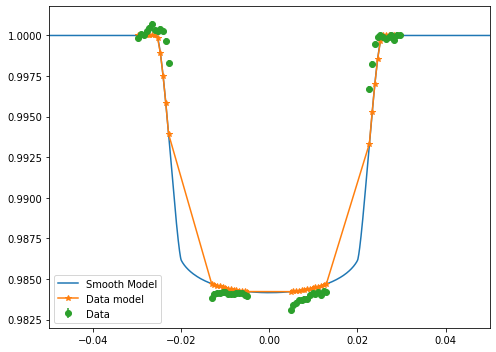

In [14]:
plt.figure(1, figsize=(7,5))
plt.plot(phase_smooth, tmod_smooth, label='Smooth Model')
plt.plot(phase_data, tmod_data, marker='*', label='Data model')
plt.errorbar(phase_data, y, yerr=err, marker='o', linestyle='none', label='Data')

plt.xlim(-0.05, 0.05)
plt.legend()
plt.tight_layout()